<h1 align="center" style="color:#DAEF0C" > Image Processing-1 Final Project 

***
</h1>
<h1 align="center" style="color:#00FFFF" > ResUNET Segmentation on Brain Tumor MRI images </h1>

### Names & Ids:-
* Abdelrahman Mahmoud Alsayed Ibrahim -> 20190732
* Salah Eldien Mamdouh -> 20190270
* Belal Kamal Ashraf -> 20190137


<h1 align="center" style="color:#B706FE">Imports

***

In [103]:
import os
import cv2
import random
import zipfile
import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns
from skimage import io
import tensorflow as tf
import keras.backend as K
from keras.layers import *
from keras.models import Model
import matplotlib.pyplot as plt
from keras.utils import plot_model
from IPython.display import display
from keras import layers, optimizers
from tensorflow.python.keras import Sequential
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler, normalize
from keras.callbacks import (
    ReduceLROnPlateau,
    EarlyStopping,
    ModelCheckpoint,
    LearningRateScheduler,
)

<h1 align="center " style="color:#06A0FE"> Data Insight 

***
</h1>
LGG Segmentation Dataset
Dataset used in:

Mateusz Buda, AshirbaniSaha, Maciej A. Mazurowski "Association of genomic subtypes of lower-grade gliomas with shape features automatically extracted by a deep learning algorithm." Computers in Biology and Medicine, 2019.

and

Maciej A. Mazurowski, Kal Clark, Nicholas M. Czarnek, Parisa Shamsesfandabadi, Katherine B. Peters, Ashirbani Saha "Radiogenomics of lower-grade glioma: algorithmically-assessed tumor shape is associated with tumor genomic subtypes and patient outcomes in a multi-institutional study with The Cancer Genome Atlas data." Journal of Neuro-Oncology, 2017.

This dataset contains brain MR images together with manual FLAIR abnormality segmentation masks.
The images were obtained from The Cancer Imaging Archive (TCIA).
They correspond to 110 patients included in The Cancer Genome Atlas (TCGA) lower-grade glioma collection with at least fluid-attenuated inversion recovery (FLAIR) sequence and genomic cluster data available.
Tumor genomic clusters and patient data is provided in data.csv file.
***

<h1 align="center" style="color:#06A0FE"> Reading and Preprocessing Data 

***

In [104]:
data = pd.read_csv("data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [105]:
data.head(10)

Patient  RNASeqCluster  MethylationCluster  miRNACluster  CNCluster  \
0  TCGA_CS_4941            2.0                 4.0             2        2.0   
1  TCGA_CS_4942            1.0                 5.0             2        1.0   
2  TCGA_CS_4943            1.0                 5.0             2        1.0   
3  TCGA_CS_4944            NaN                 5.0             2        1.0   
4  TCGA_CS_5393            4.0                 5.0             2        1.0   
5  TCGA_CS_5395            2.0                 4.0             2        2.0   
6  TCGA_CS_5396            3.0                 3.0             2        3.0   
7  TCGA_CS_5397            NaN                 4.0             1        2.0   
8  TCGA_CS_6186            2.0                 4.0             1        2.0   
9  TCGA_CS_6188            2.0                 4.0             3        2.0   

   RPPACluster  OncosignCluster  COCCluster  histological_type  \
0          NaN              3.0           2                1.0   
1          1.0              2.0           1                1.0   
2          2.0              2.0           1                1.0   
3          2.0              1.0           1                1.0   
4          2.0              3.0           1                1.0   
5          NaN              3.0           2                3.0   
6          2.0              2.0           3                3.0   
7          3.0              3.0           2                1.0   
8          1.0              3.0           2                2.0   
9          3.0              3.0           2                1.0   

   neoplasm_histologic_grade  tumor_tissue_site  laterality  tumor_location  \
0                        2.0                1.0         3.0             2.0   
1                        2.0                1.0         3.0             2.0   
2                        2.0                1.0         1.0             2.0   
3                        1.0                1.0         3.0             6.0   
4                        2.0                1.0         1.0             6.0   
5                        1.0                1.0         3.0             5.0   
6                        2.0                1.0         3.0             2.0   
7                        2.0                1.0         1.0             6.0   
8                        2.0                1.0         3.0             2.0   
9                        2.0                1.0         3.0             6.0   

   gender  age_at_initial_pathologic  race  ethnicity  death01  
0     2.0                       67.0   3.0        2.0      1.0  
1     1.0                       44.0   2.0        NaN      1.0  
2     2.0                       37.0   3.0        NaN      0.0  
3     2.0                       50.0   3.0        NaN      0.0  
4     2.0                       39.0   3.0        NaN      0.0  
5     2.0                       43.0   2.0        NaN      1.0  
6     1.0                       53.0   3.0        2.0      0.0  
7     1.0                       54.0   3.0        2.0      1.0  
8     2.0                       58.0   3.0        2.0      1.0  
9     2.0                       48.0   3.0        2.0      0.0

In [106]:
data_map = []
for sub_dir_path in glob("MRI/" + "*"):
    # if os.path.isdir(sub_path_dir):
    try:
        dir_name = sub_dir_path.split("/")[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + "/" + filename
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print(e)

In [107]:
df = pd.DataFrame({"patient_id": data_map[::2], "path": data_map[1::2]})
df.iloc[0]

patient_id                                TCGA_CS_6667_20011105
path          MRI/TCGA_CS_6667_20011105/TCGA_CS_6667_2001110...
Name: 0, dtype: object

In [108]:
df_imgs = df[~df["path"].str.contains("mask")]
df_masks = df[df["path"].str.contains("mask")]


# File path line length images for later sorting
BASE_LEN = 48  # len(MRI/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif)
END_IMG_LEN = 4  # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->.tif)
END_MASK_LEN = 9  # (/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->_mask.tif)

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x: int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x: int(x[BASE_LEN:-END_MASK_LEN]))

# Sorting check
idx = random.randint(0, len(imgs) - 1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: MRI/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_1.tif 
Path to the Mask: MRI/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_1_mask.tif


In [109]:
# Final dataframe
brain_df = pd.DataFrame(
    {"patient_id": df_imgs.patient_id.values, "image_path": imgs, "mask_path": masks}
)


def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0:
        return 1
    else:
        return 0


brain_df["mask"] = brain_df["mask_path"].apply(lambda x: pos_neg_diagnosis(x))
brain_df

patient_id  \
0     TCGA_CS_6667_20011105   
1     TCGA_CS_6667_20011105   
2     TCGA_CS_6667_20011105   
3     TCGA_CS_6667_20011105   
4     TCGA_CS_6667_20011105   
...                     ...   
3924  TCGA_FG_A60K_20040224   
3925  TCGA_FG_A60K_20040224   
3926  TCGA_FG_A60K_20040224   
3927  TCGA_FG_A60K_20040224   
3928  TCGA_FG_A60K_20040224   

                                             image_path  \
0     MRI/TCGA_CS_6667_20011105/TCGA_CS_6667_2001110...   
1     MRI/TCGA_DU_8164_19970111/TCGA_DU_8164_1997011...   
2     MRI/TCGA_DU_8168_19970503/TCGA_DU_8168_1997050...   
3     MRI/TCGA_DU_7300_19910814/TCGA_DU_7300_1991081...   
4     MRI/TCGA_HT_7475_19970918/TCGA_HT_7475_1997091...   
...                                                 ...   
3924  MRI/TCGA_HT_A61A_20000127/TCGA_HT_A61A_2000012...   
3925  MRI/TCGA_HT_A61B_19991127/TCGA_HT_A61B_1999112...   
3926  MRI/TCGA_HT_A61A_20000127/TCGA_HT_A61A_2000012...   
3927  MRI/TCGA_HT_A61B_19991127/TCGA_HT_A61B_1999112...   
3928  MRI/TCGA_HT_A61A_20000127/TCGA_HT_A61A_2000012...   

                                              mask_path  mask  
0     MRI/TCGA_CS_6667_20011105/TCGA_CS_6667_2001110...     0  
1     MRI/TCGA_DU_8164_19970111/TCGA_DU_8164_1997011...     0  
2     MRI/TCGA_DU_8168_19970503/TCGA_DU_8168_1997050...     0  
3     MRI/TCGA_DU_7300_19910814/TCGA_DU_7300_1991081...     0  
4     MRI/TCGA_HT_7475_19970918/TCGA_HT_7475_1997091...     0  
...                                                 ...   ...  
3924  MRI/TCGA_HT_A61A_20000127/TCGA_HT_A61A_2000012...     0  
3925  MRI/TCGA_HT_A61B_19991127/TCGA_HT_A61B_1999112...     0  
3926  MRI/TCGA_HT_A61A_20000127/TCGA_HT_A61A_2000012...     0  
3927  MRI/TCGA_HT_A61B_19991127/TCGA_HT_A61B_1999112...     0  
3928  MRI/TCGA_HT_A61A_20000127/TCGA_HT_A61A_2000012...     0  

[3929 rows x 4 columns]

<h1 align="center" style="color:#06FE59"> Data Visualization 

***

In [110]:
brain_df["mask"].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

In [111]:
import plotly.graph_objects as go  # using plotly to create interactive plots

fig = go.Figure(
    [
        go.Bar(
            x=brain_df["mask"].value_counts().index,
            y=brain_df["mask"].value_counts(),
            width=[0.4, 0.4],
        )
    ]
)
fig.update_traces(
    marker_color="rgb(158,202,225)",
    marker_line_color="rgb(8,48,107)",
    marker_line_width=4,
    opacity=0.4,
)
fig.update_layout(
    title_text="Mask Count Plot",
    width=700,
    height=550,
    yaxis=dict(title_text="Count", tickmode="array", titlefont=dict(size=20)),
)
fig.update_yaxes(automargin=True)
fig.show()

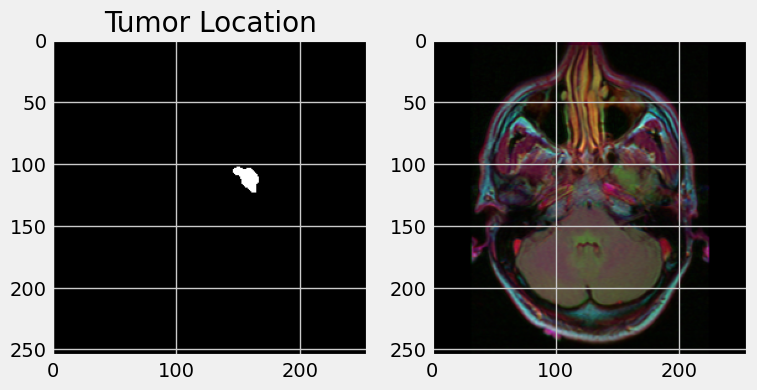

In [112]:
for i in range(len(brain_df)):
    if cv2.imread(brain_df.mask_path[i]).max() > 0:
        break

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(cv2.imread(brain_df.mask_path[i]))
plt.title("Tumor Location")

plt.subplot(1, 2, 2)
plt.imshow(cv2.imread(brain_df.image_path[i]))

In [113]:
cv2.imread(brain_df.mask_path[i]).max(), cv2.imread(brain_df.mask_path[i]).min()

(255, 0)

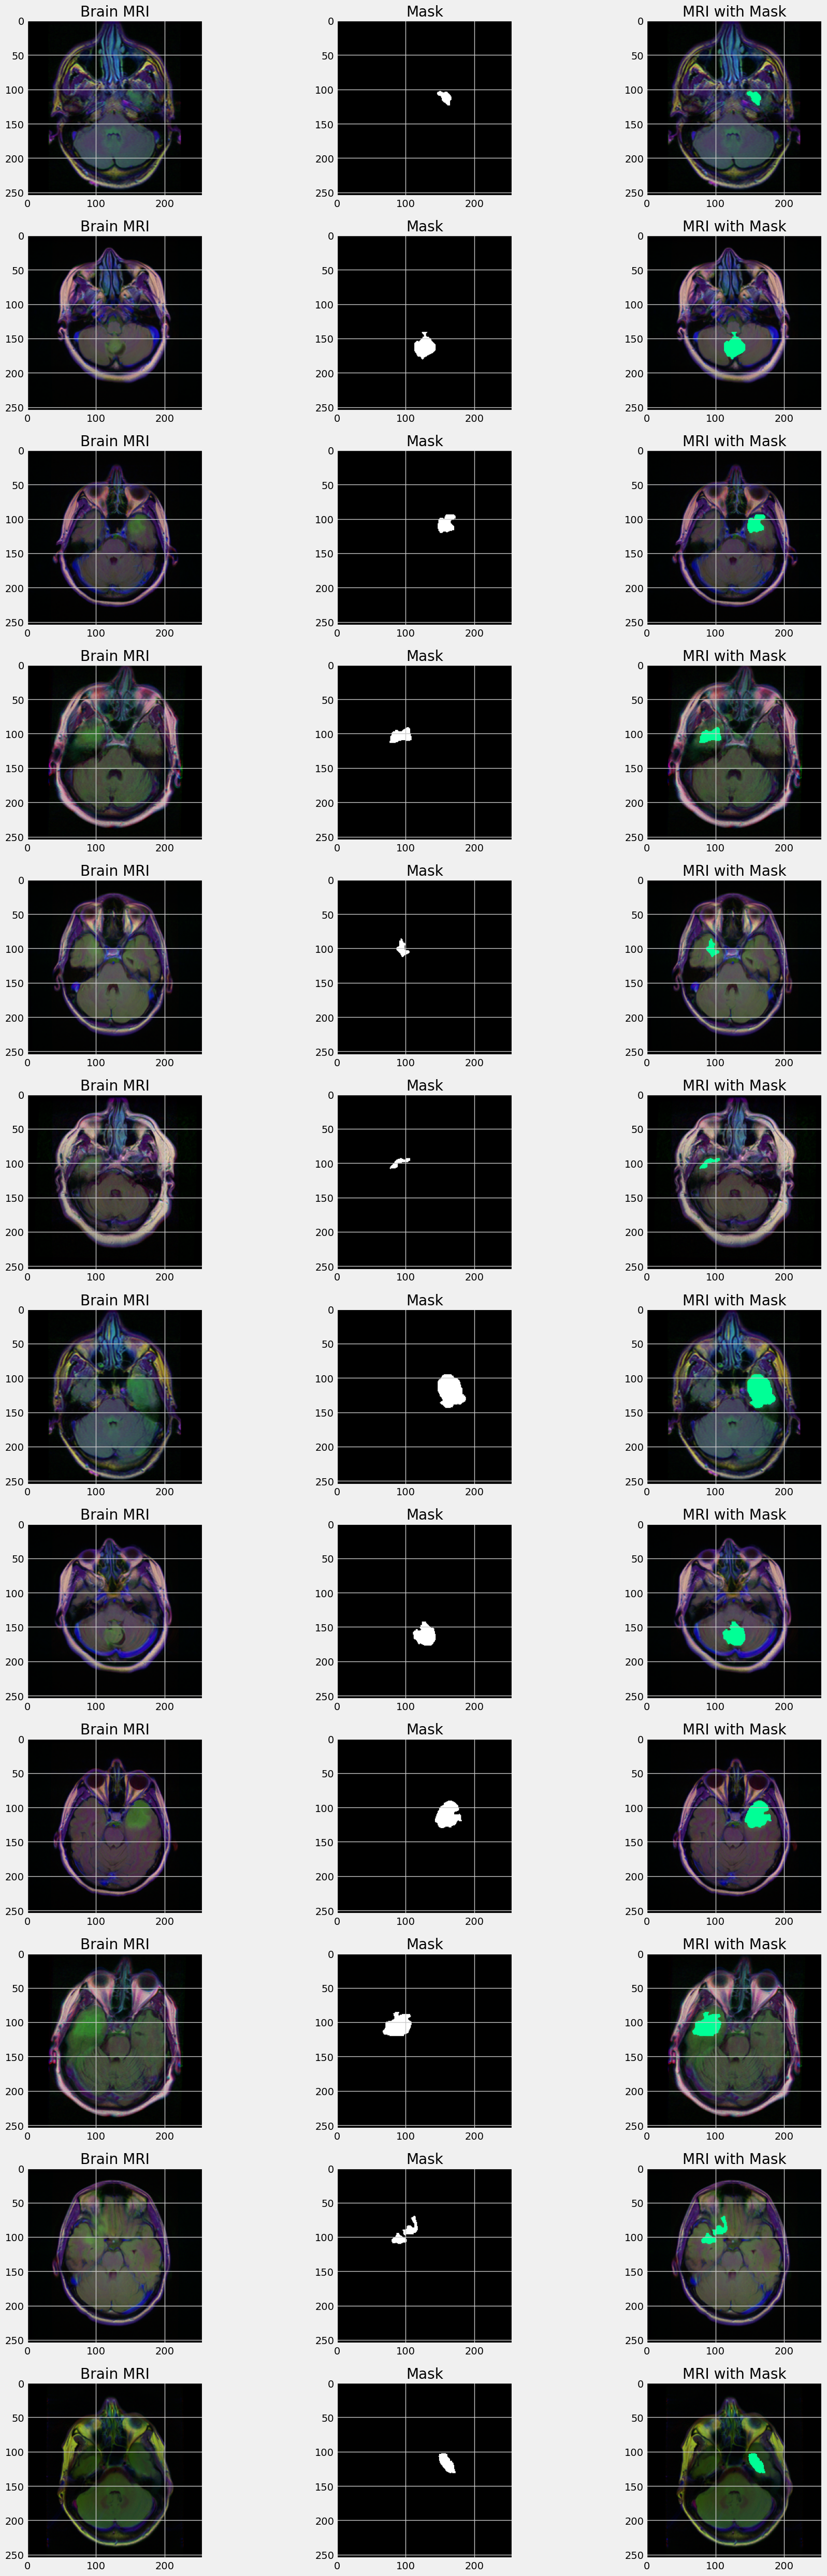

In [114]:
count = 0
i = 0
fig, axs = plt.subplots(12, 3, figsize=(20, 50))
for mask in brain_df["mask"]:
    if mask == 1:
        img = io.imread(brain_df.image_path[i])
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)

        mask = io.imread(brain_df.mask_path[i])
        axs[count][1].title.set_text("Mask")
        axs[count][1].imshow(mask, cmap="gray")

        img[mask == 255] = (0, 255, 150)  # change pixel color at the position of mask
        axs[count][2].title.set_text("MRI with Mask")
        axs[count][2].imshow(img)
        count += 1
    i += 1
    if count == 12:
        break

fig.tight_layout()

<h1 align="center" style="color:#06A0FE"> Data Prepration 

***

In [115]:
brain_df_train = brain_df.drop(columns=["patient_id"])
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
brain_df_train["mask"] = brain_df_train["mask"].apply(lambda x: str(x))
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [116]:
train, test = train_test_split(brain_df_train, test_size=0.15)

In [117]:
datagen = ImageDataGenerator(rescale=1.0 / 255.0, validation_split=0.1)

train_generator = datagen.flow_from_dataframe(
    train,
    directory="./",
    x_col="image_path",
    y_col="mask",
    subset="training",
    class_mode="categorical",
    batch_size=16,
    shuffle=True,
    target_size=(256, 256),
)
valid_generator = datagen.flow_from_dataframe(
    train,
    directory="./",
    x_col="image_path",
    y_col="mask",
    subset="validation",
    class_mode="categorical",
    batch_size=16,
    shuffle=True,
    target_size=(256, 256),
)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_generator = test_datagen.flow_from_dataframe(
    test,
    directory="./",
    x_col="image_path",
    y_col="mask",
    class_mode="categorical",
    batch_size=16,
    shuffle=False,
    target_size=(256, 256),
)

Found 3006 validated image filenames belonging to 2 classes.
Found 333 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


<h1 align="center" style="color: #72F808"> ResNet50 Model for Classification

***
<img src="resnet50.png" width="1200" height="400">

In [118]:
from keras.applications.resnet import ResNet50

clf_model = ResNet50(
    weights="imagenet", include_top=False, input_tensor=Input(shape=(256, 256, 3))
)
clf_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [119]:
for layer in clf_model.layers:
    layers.trainable = False

In [120]:
head = clf_model.output
head = AveragePooling2D(pool_size=(4, 4))(head)
head = Flatten(name="Flatten")(head)
head = Dense(256, activation="relu")(head)
head = Dropout(0.3)(head)
head = Dense(256, activation="relu")(head)
head = Dropout(0.3)(head)
head = Dense(2, activation="softmax")(head)

RESNET50 = Model(clf_model.input, head)
RESNET50.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)
RESNET50.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [121]:
earlystopping = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=15)
checkpointer = ModelCheckpoint(
    filepath="clf-resnet-weights.hdf5", verbose=1, save_best_only=True
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", mode="min", verbose=1, patience=10, min_delta=0.0001, factor=0.2
)
callbacks = [checkpointer, earlystopping, reduce_lr]

In [122]:
h = RESNET50.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=20,
    validation_data=valid_generator,
    validation_steps=valid_generator.n // valid_generator.batch_size,
    callbacks=[checkpointer, earlystopping],
)
# 45 mins 

Epoch 1/20


2023-05-21 01:07:06.581012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


187/187 [==============================] - ETA: 0s - loss: 0.6085 - accuracy: 0.7421

2023-05-21 01:09:33.718730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 6.65375, saving model to clf-resnet-weights.hdf5
187/187 [==============================] - 156s 776ms/step - loss: 0.6085 - accuracy: 0.7421 - val_loss: 6.6538 - val_accuracy: 0.6438
Epoch 2/20
187/187 [==============================] - ETA: 0s - loss: 0.4097 - accuracy: 0.8264
Epoch 2: val_loss improved from 6.65375 to 0.66471, saving model to clf-resnet-weights.hdf5
187/187 [==============================] - 136s 725ms/step - loss: 0.4097 - accuracy: 0.8264 - val_loss: 0.6647 - val_accuracy: 0.6469
Epoch 3/20
187/187 [==============================] - ETA: 0s - loss: 0.4506 - accuracy: 0.8161
Epoch 3: val_loss did not improve from 0.66471
187/187 [==============================] - 132s 705ms/step - loss: 0.4506 - accuracy: 0.8161 - val_loss: 133.6552 - val_accuracy: 0.6438
Epoch 4/20
187/187 [==============================] - ETA: 0s - loss: 0.3396 - accuracy: 0.8579
Epoch 4: val_loss improved from 0.66471 to 0.66270, saving model to clf-resne

In [123]:
# saving model achitecture in json file
model_json = RESNET50.to_json()
with open("clf-resnet-model.json", "w") as json_file:
    json_file.write(model_json)

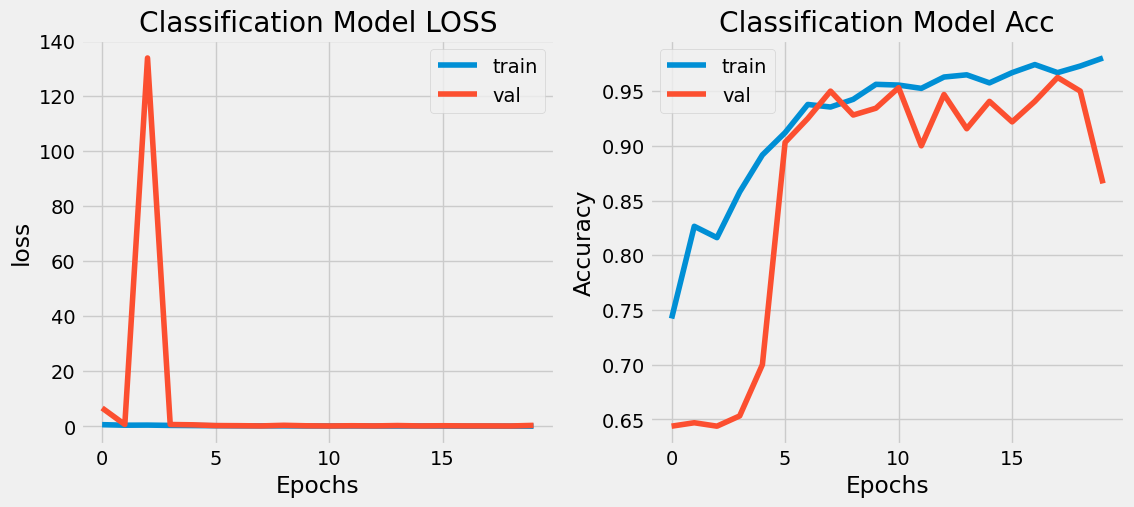

In [124]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(h.history["loss"])
plt.plot(h.history["val_loss"])
plt.title("Classification Model LOSS")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.legend(["train", "val"])

plt.subplot(1, 2, 2)
plt.plot(h.history["accuracy"])
plt.plot(h.history["val_accuracy"])
plt.title("Classification Model Acc")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "val"])

In [125]:
_, acc = RESNET50.evaluate(test_generator)
print("Test accuracy : {} %".format(acc * 100))

37/37 [==============================] - 9s 226ms/step - loss: 0.3004 - accuracy: 0.8780
Test accuracy : 87.79661059379578 %


2023-05-21 01:51:56.143310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - 10s 238ms/step
0.8779661016949153
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       385
           1       0.96      0.68      0.79       205

    accuracy                           0.88       590
   macro avg       0.91      0.83      0.85       590
weighted avg       0.89      0.88      0.87       590



<AxesSubplot: >

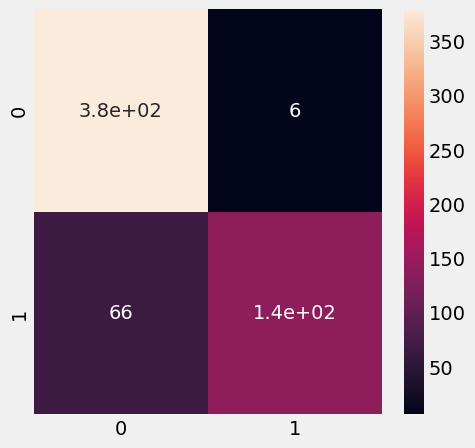

In [126]:
prediction = RESNET50.predict(test_generator)

pred = np.argmax(prediction, axis=1)
# pred = np.asarray(pred).astype('str')
original = np.asarray(test["mask"]).astype("int")

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

accuracy = accuracy_score(original, pred)
print(accuracy)

cm = confusion_matrix(original, pred)

report = classification_report(original, pred, labels=[0, 1])
print(report)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True)

<h1 align="center" style="color:#FF007F"> ResUNET Model for Segmentation

***
<img src="https://drive.google.com/uc?id=10XpINWmLDApPhIjxq_o8aTbeRjXIQRTD" width="1200" height="400" >

In [127]:
brain_df_mask = brain_df[brain_df["mask"] == 1]
brain_df_mask.shape

(1373, 4)

In [128]:
# creating test, train and val sets
X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)
print(
    "Train size is {}, valid size is {} & test size is {}".format(
        len(X_train), len(X_val), len(X_test)
    )
)

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask = list(X_val.mask_path)

Train size is 1167, valid size is 103 & test size is 103


In [129]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(
        self,
        ids,
        mask,
        image_dir="./",
        batch_size=16,
        img_h=256,
        img_w=256,
        shuffle=True,
    ):
        self.ids = ids
        self.mask = mask
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.img_h = img_h
        self.img_w = img_w
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        "Get the number of batches per epoch"

        return int(np.floor(len(self.ids)) / self.batch_size)

    def __getitem__(self, index):
        "Generate a batch of data"

        # generate index of batch_size length
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]

        # get the ImageId corresponding to the indexes created above based on batch size
        list_ids = [self.ids[i] for i in indexes]

        # get the MaskId corresponding to the indexes created above based on batch size
        list_mask = [self.mask[i] for i in indexes]

        # generate data for the X(features) and y(label)
        X, y = self.__data_generation(list_ids, list_mask)

        # returning the data
        return X, y

    def on_epoch_end(self):
        "Used for updating the indices after each epoch, once at the beginning as well as at the end of each epoch"

        # getting the array of indices based on the input dataframe
        self.indexes = np.arange(len(self.ids))

        # if shuffle is true, shuffle the indices
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_ids, list_mask):
        "generate the data corresponding the indexes in a given batch of images"

        # create empty arrays of shape (batch_size,height,width,depth)
        # Depth is 3 for input and depth is taken as 1 for output becasue mask consist only of 1 channel.
        X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
        y = np.empty((self.batch_size, self.img_h, self.img_w, 1))

        # iterate through the dataframe rows, whose size is equal to the batch_size
        for i in range(len(list_ids)):
            # path of the image
            img_path = str(list_ids[i])

            # mask path
            mask_path = str(list_mask[i])

            # reading the original image and the corresponding mask image
            img = io.imread(img_path)
            mask = io.imread(mask_path)

            # resizing and coverting them to array of type float64
            img = cv2.resize(img, (self.img_h, self.img_w))
            img = np.array(img, dtype=np.float64)

            mask = cv2.resize(mask, (self.img_h, self.img_w))
            mask = np.array(mask, dtype=np.float64)

            # standardising
            img -= img.mean()
            img /= img.std()

            mask -= mask.mean()
            mask /= mask.std()

            # Adding image to the empty array
            X[i,] = img

            # expanding the dimnesion of the image from (256,256) to (256,256,1)
            y[i,] = np.expand_dims(mask, axis=2)

        # normalizing y
        y = (y > 0).astype(int)

        return X, y


train_data = DataGenerator(train_ids, train_mask)
val_data = DataGenerator(val_ids, val_mask)

In [130]:
def resblock(X, f):
    """
    function for creating res block
    """
    X_copy = X  # copy of input

    # main path
    X = Conv2D(f, kernel_size=(1, 1), kernel_initializer="he_normal")(X)
    X = BatchNormalization()(X)
    X = Activation("relu")(X)

    X = Conv2D(f, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(X)
    X = BatchNormalization()(X)

    # shortcut path
    X_copy = Conv2D(f, kernel_size=(1, 1), kernel_initializer="he_normal")(X_copy)
    X_copy = BatchNormalization()(X_copy)

    # Adding the output from main path and short path together
    X = Add()([X, X_copy])
    X = Activation("relu")(X)

    return X


def upsample_concat(x, skip):
    """
    funtion for upsampling image
    """
    X = UpSampling2D((2, 2))(x)
    merge = Concatenate()([X, skip])

    return merge


def ResUnet():
    input_shape = (256, 256, 3)
    X_input = Input(input_shape)  # iniating tensor of input shape

    #################### Encoder ########################
    # Stage 1
    conv_1 = Conv2D(
        16, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(X_input)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Conv2D(
        16, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv_1)
    conv_1 = BatchNormalization()(conv_1)
    pool_1 = MaxPool2D((2, 2))(conv_1)

    # stage 2
    conv_2 = resblock(pool_1, 32)
    pool_2 = MaxPool2D((2, 2))(conv_2)

    # Stage 3
    conv_3 = resblock(pool_2, 64)
    pool_3 = MaxPool2D((2, 2))(conv_3)

    # Stage 4
    conv_4 = resblock(pool_3, 128)
    pool_4 = MaxPool2D((2, 2))(conv_4)
    ###################################################

    ################### Bottle Neck ###################
    conv_5 = resblock(pool_4, 256)
    ###################################################

    #################### Decoder ######################
    # Upsample Stage 1
    up_1 = upsample_concat(conv_5, conv_4)
    up_1 = resblock(up_1, 128)

    # Upsample Stage 2
    up_2 = upsample_concat(up_1, conv_3)
    up_2 = resblock(up_2, 64)

    # Upsample Stage 3
    up_3 = upsample_concat(up_2, conv_2)
    up_3 = resblock(up_3, 32)

    # Upsample Stage 4
    up_4 = upsample_concat(up_3, conv_1)
    up_4 = resblock(up_4, 16)

    # final output
    out = Conv2D(
        1, (1, 1), kernel_initializer="he_normal", padding="same", activation="sigmoid"
    )(up_4)
    ###################################################

    seg_model = Model(X_input, out)
    return seg_model

In [131]:
def dice_coef(y_true, y_pred, smooth=1):
    """
    A statistical tool which measures the similarity between two sets of dat    
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_loss(y_true, y_pred, smooth=1):
    return 1.0 - dice_coef(y_true, y_pred, smooth)


def iou(y_true, y_pred):  
    """
    IOU(Intersection over Union) is a term used to describe the extent of overlap of two boxes. 
    The greater the region of overlap, the greater the IOU.
    """
    y_true = tf.keras.backend.flatten(y_true)
    y_pred = tf.keras.backend.flatten(y_pred)
    y_true_f = tf.cast(y_true, tf.float32)
    y_pred_f = tf.cast(y_pred, tf.float32)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = (
        tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    )  # sum areas and sub intersection
    return (intersection + 1e-7) / (union + 1e-7)


def iou_loss(y_true, y_pred):  
    return 1.0 - iou(y_true, y_pred)


def iou_coef(
    y_true, y_pred, smooth=1
):  # analyze only ones forms. dont calculate zero sections
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
    union = K.sum(y_true, [1, 2, 3]) + K.sum(y_pred, [1, 2, 3]) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

In [132]:
learning_rate = 0.001
optimizer = optimizers.Adam(learning_rate)
RESUNET = ResUnet()

RESUNET.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy", dice_coef, iou_coef],
)
RESUNET.summary()
earlystopping = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=20)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_54 (Conv2D)             (None, 256, 256, 16  448         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_52 (BatchN  (None, 256, 256, 16  64         ['conv2d_54[0][0]']              
 ormalization)                  )                                                           

In [133]:
h = RESUNET.fit(
    train_data, epochs=20, validation_data=val_data, callbacks=[earlystopping]
)

Epoch 1/20


2023-05-21 01:52:07.974956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - ETA: 0s - loss: 0.2881 - accuracy: 0.9402 - dice_coef: 0.1452 - iou_coef: 0.0750

2023-05-21 01:53:00.907166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - 57s 716ms/step - loss: 0.2881 - accuracy: 0.9402 - dice_coef: 0.1452 - iou_coef: 0.0750 - val_loss: 0.1834 - val_accuracy: 0.9651 - val_dice_coef: 0.0544 - val_iou_coef: 0.0262
Epoch 2/20
72/72 [==============================] - 48s 661ms/step - loss: 0.1198 - accuracy: 0.9843 - dice_coef: 0.2709 - iou_coef: 0.1424 - val_loss: 0.1606 - val_accuracy: 0.9727 - val_dice_coef: 0.1572 - val_iou_coef: 0.0757
Epoch 3/20
72/72 [==============================] - 47s 658ms/step - loss: 0.0757 - accuracy: 0.9871 - dice_coef: 0.3896 - iou_coef: 0.2130 - val_loss: 0.1411 - val_accuracy: 0.9603 - val_dice_coef: 0.3587 - val_iou_coef: 0.2031
Epoch 4/20
72/72 [==============================] - 48s 660ms/step - loss: 0.0552 - accuracy: 0.9886 - dice_coef: 0.4888 - iou_coef: 0.2786 - val_loss: 0.0583 - val_accuracy: 0.9874 - val_dice_coef: 0.5152 - val_iou_coef: 0.2931
Epoch 5/20
72/72 [==============================] - 47s 657ms/step - loss: 0.0412 - accuracy: 0

In [134]:
# saving model achitecture in json file
seg_model_json = RESUNET.to_json()
with open("ResUNet-seg-model.json", "w") as json_file:
    json_file.write(seg_model_json)

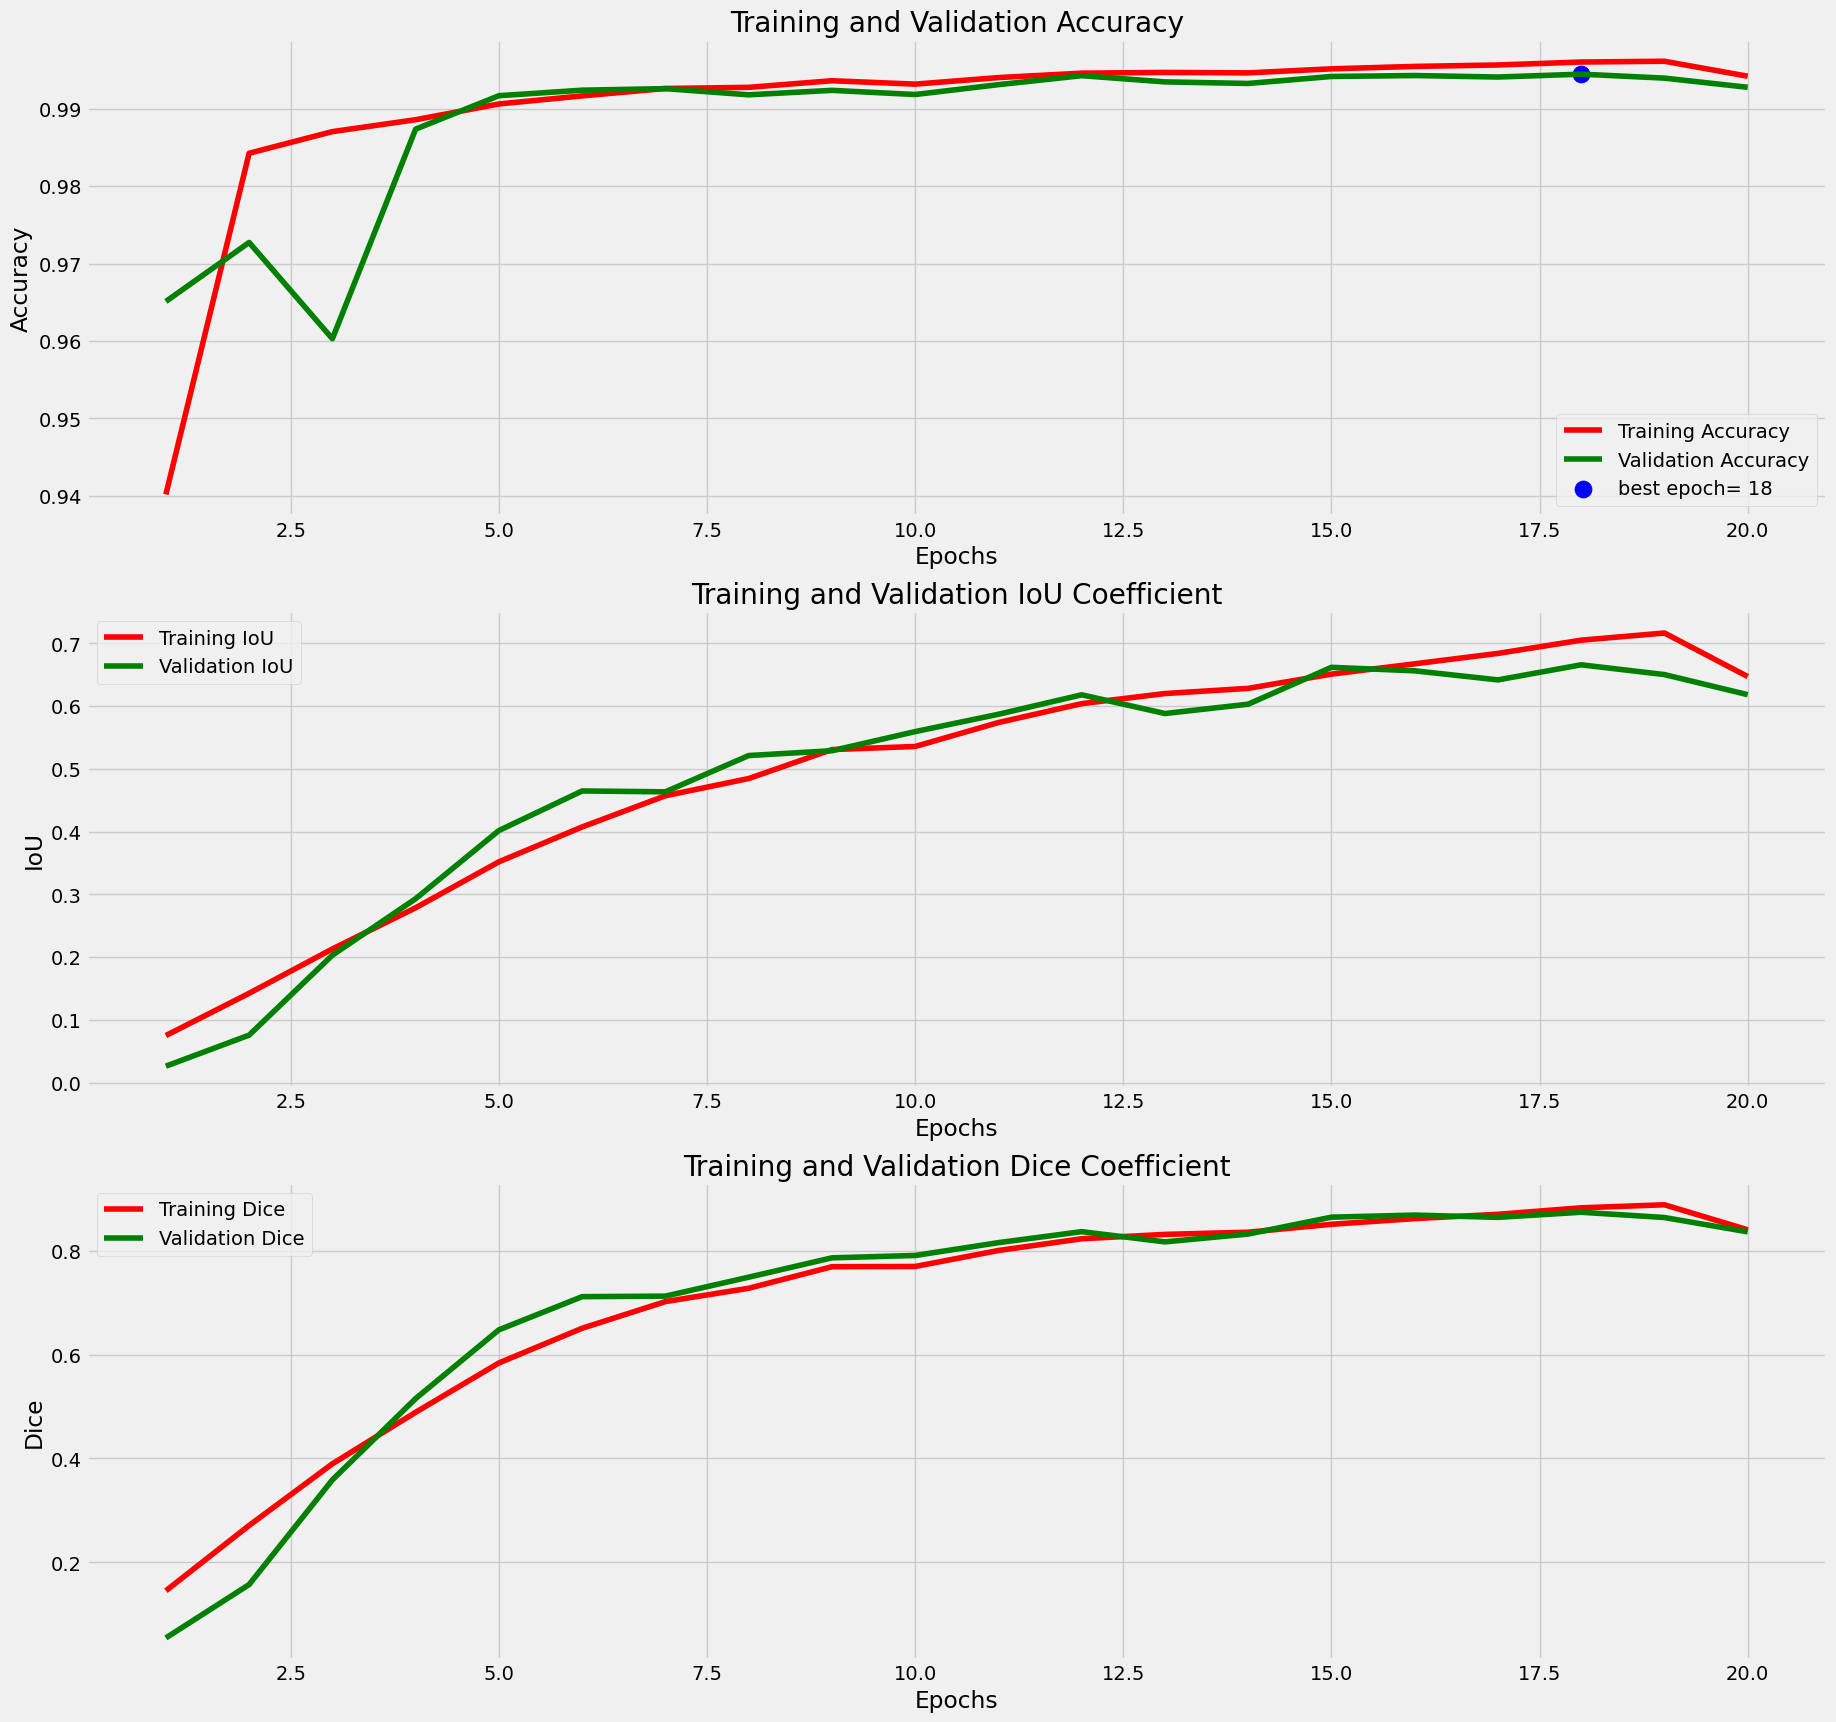

In [135]:
def plot_training(hist):
    tr_acc = hist.history["accuracy"]
    tr_iou = hist.history["iou_coef"]
    tr_dice = hist.history["dice_coef"]

    val_acc = hist.history["val_accuracy"]
    val_iou = hist.history["val_iou_coef"]
    val_dice = hist.history["val_dice_coef"]

    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    Epochs = [i + 1 for i in range(len(tr_acc))]

    acc_label = f"best epoch= {str(index_acc + 1)}"

    plt.figure(figsize=(20, 20))
    plt.style.use("fivethirtyeight")

    plt.subplot(3, 1, 1)
    plt.plot(Epochs, tr_acc, "r", label="Training Accuracy")
    plt.plot(Epochs, val_acc, "g", label="Validation Accuracy")
    plt.scatter(index_acc + 1, acc_highest, s=150, c="blue", label=acc_label)
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(Epochs, tr_iou, "r", label="Training IoU")
    plt.plot(Epochs, val_iou, "g", label="Validation IoU")
    plt.title("Training and Validation IoU Coefficient")
    plt.xlabel("Epochs")
    plt.ylabel("IoU")
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(Epochs, tr_dice, "r", label="Training Dice")
    plt.plot(Epochs, val_dice, "g", label="Validation Dice")
    plt.title("Training and Validation Dice Coefficient")
    plt.xlabel("Epochs")
    plt.ylabel("Dice")
    plt.legend()

    plt.tight_layout
    plt.show()


plot_training(h)

<h1 align="center" style="color: #FF7E04"> Prediction Pipeline 

***

In [136]:
test_ids = list(X_test.image_path)
test_mask = list(X_test.mask_path)
test_data = DataGenerator(test_ids, test_mask)
_, accuracy, dice_coef, iou_coef = RESUNET.evaluate(test_data)
print(
    f"Segmentation Test Results:- Accuracy: {accuracy} - DiceCoeff: {dice_coef} - IOU: {iou_coef}"
)

6/6 [==============================] - 1s 194ms/step - loss: 0.0218 - accuracy: 0.9926 - dice_coef: 0.7882 - iou_coef: 0.5401
Segmentation Test Results:- Accuracy: 0.9925885200500488 - DiceCoeff: 0.7881944179534912 - IOU: 0.5400678515434265


In [137]:
def prediction(test, model, model_seg):
    """
    Predcition function which takes dataframe containing ImageID as Input and perform 2 type of prediction on the image
    Initially, image is passed through the classification network which predicts whether the image has defect or not, if the model
    is 99% sure that the image has no defect, then the image is labeled as no-defect, if the model is not sure, it passes the image to the
    segmentation network, it again checks if the image has defect or not, if it has defect, then the type and location of defect is found
    """
    # empty list to store results
    mask, image_id, has_mask = [], [], []

    # itetrating through each image in test data
    for i in test.image_path:
        img = io.imread(i)
        # normalizing
        img = img * 1.0 / 255.0
        # reshaping
        img = cv2.resize(img, (256, 256))
        # converting img into array
        img = np.array(img, dtype=np.float64)
        # reshaping the image from 256,256,3 to 1,256,256,3
        img = np.reshape(img, (1, 256, 256, 3))

        # making prediction for tumor in image
        is_defect = model.predict(img)

        # if tumour is not present we append the details of the image to the list
        if np.argmax(is_defect) == 0:
            image_id.append(i)
            has_mask.append(0)
            mask.append("No mask :)")
            continue

        # Creating a empty array of shape 1,256,256,1
        X = np.empty((1, 256, 256, 3))
        # read the image
        img = io.imread(i)
        # resizing the image and coverting them to array of type float64
        img = cv2.resize(img, (256, 256))
        img = np.array(img, dtype=np.float64)

        # standardising the image
        img -= img.mean()
        img /= img.std()
        # converting the shape of image from 256,256,3 to 1,256,256,3
        X[0,] = img

        # make prediction of mask
        predict = model_seg.predict(X)

        # if sum of predicted mask is 0 then there is not tumour
        if predict.round().astype(int).sum() == 0:
            image_id.append(i)
            has_mask.append(0)
            mask.append("No mask :)")
        else:
            # if the sum of pixel values are more than 0, then there is tumour
            image_id.append(i)
            has_mask.append(1)
            mask.append(predict)

    return pd.DataFrame(
        {"image_path": image_id, "predicted_mask": mask, "has_mask": has_mask}
    )

In [138]:
# making prediction
df_pred = prediction(test, RESNET50, RESUNET)
df_pred

2023-05-21 02:08:07.061565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 24ms/step


2023-05-21 02:08:09.888902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 23ms/step


image_path  \
0    MRI/TCGA_DU_6404_19850629/TCGA_DU_6404_1985062...   
1    MRI/TCGA_DU_5854_19951104/TCGA_DU_5854_1995110...   
2    MRI/TCGA_HT_7690_19960312/TCGA_HT_7690_1996031...   
3    MRI/TCGA_CS_4943_20000902/TCGA_CS_4943_2000090...   
4    MRI/TCGA_DU_5853_19950823/TCGA_DU_5853_1995082...   
..                                                 ...   
585  MRI/TCGA_CS_6666_20011109/TCGA_CS_6666_2001110...   
586  MRI/TCGA_HT_7616_19940813/TCGA_HT_7616_1994081...   
587  MRI/TCGA_CS_4942_19970222/TCGA_CS_4942_1997022...   
588  MRI/TCGA_HT_7605_19950916/TCGA_HT_7605_1995091...   
589  MRI/TCGA_FG_7634_20000128/TCGA_FG_7634_2000012...   

                                        predicted_mask  has_mask  
0                                           No mask :)         0  
1                                           No mask :)         0  
2    [[[[0.00166495], [0.00119236], [0.00144748], [...         1  
3                                           No mask :)         0  
4                                           No mask :)         0  
..                                                 ...       ...  
585                                         No mask :)         0  
586                                         No mask :)         0  
587                                         No mask :)         0  
588  [[[[0.00331732], [0.00239581], [0.00194221], [...         1  
589                                         No mask :)         0  

[590 rows x 3 columns]

In [139]:
# merging original and prediction df
df_pred = test.merge(df_pred, on="image_path")
df_pred.head(10)

image_path  \
0  MRI/TCGA_DU_6404_19850629/TCGA_DU_6404_1985062...   
1  MRI/TCGA_DU_5854_19951104/TCGA_DU_5854_1995110...   
2  MRI/TCGA_HT_7690_19960312/TCGA_HT_7690_1996031...   
3  MRI/TCGA_CS_4943_20000902/TCGA_CS_4943_2000090...   
4  MRI/TCGA_DU_5853_19950823/TCGA_DU_5853_1995082...   
5  MRI/TCGA_FG_6690_20020226/TCGA_FG_6690_2002022...   
6  MRI/TCGA_DU_6405_19851005/TCGA_DU_6405_1985100...   
7  MRI/TCGA_DU_8167_19970402/TCGA_DU_8167_1997040...   
8  MRI/TCGA_HT_7684_19950816/TCGA_HT_7684_1995081...   
9  MRI/TCGA_FG_6689_20020326/TCGA_FG_6689_2002032...   

                                           mask_path mask  \
0  MRI/TCGA_DU_6404_19850629/TCGA_DU_6404_1985062...    0   
1  MRI/TCGA_DU_5854_19951104/TCGA_DU_5854_1995110...    0   
2  MRI/TCGA_HT_7690_19960312/TCGA_HT_7690_1996031...    1   
3  MRI/TCGA_CS_4943_20000902/TCGA_CS_4943_2000090...    0   
4  MRI/TCGA_DU_5853_19950823/TCGA_DU_5853_1995082...    0   
5  MRI/TCGA_FG_6690_20020226/TCGA_FG_6690_2002022...    0   
6  MRI/TCGA_DU_6405_19851005/TCGA_DU_6405_1985100...    1   
7  MRI/TCGA_DU_8167_19970402/TCGA_DU_8167_1997040...    0   
8  MRI/TCGA_HT_7684_19950816/TCGA_HT_7684_1995081...    1   
9  MRI/TCGA_FG_6689_20020326/TCGA_FG_6689_2002032...    0   

                                      predicted_mask  has_mask  
0                                         No mask :)         0  
1                                         No mask :)         0  
2  [[[[0.00166495], [0.00119236], [0.00144748], [...         1  
3                                         No mask :)         0  
4                                         No mask :)         0  
5                                         No mask :)         0  
6                                         No mask :)         0  
7                                         No mask :)         0  
8  [[[[0.00168849], [0.00120769], [0.00145471], [...         1  
9                                         No mask :)         0

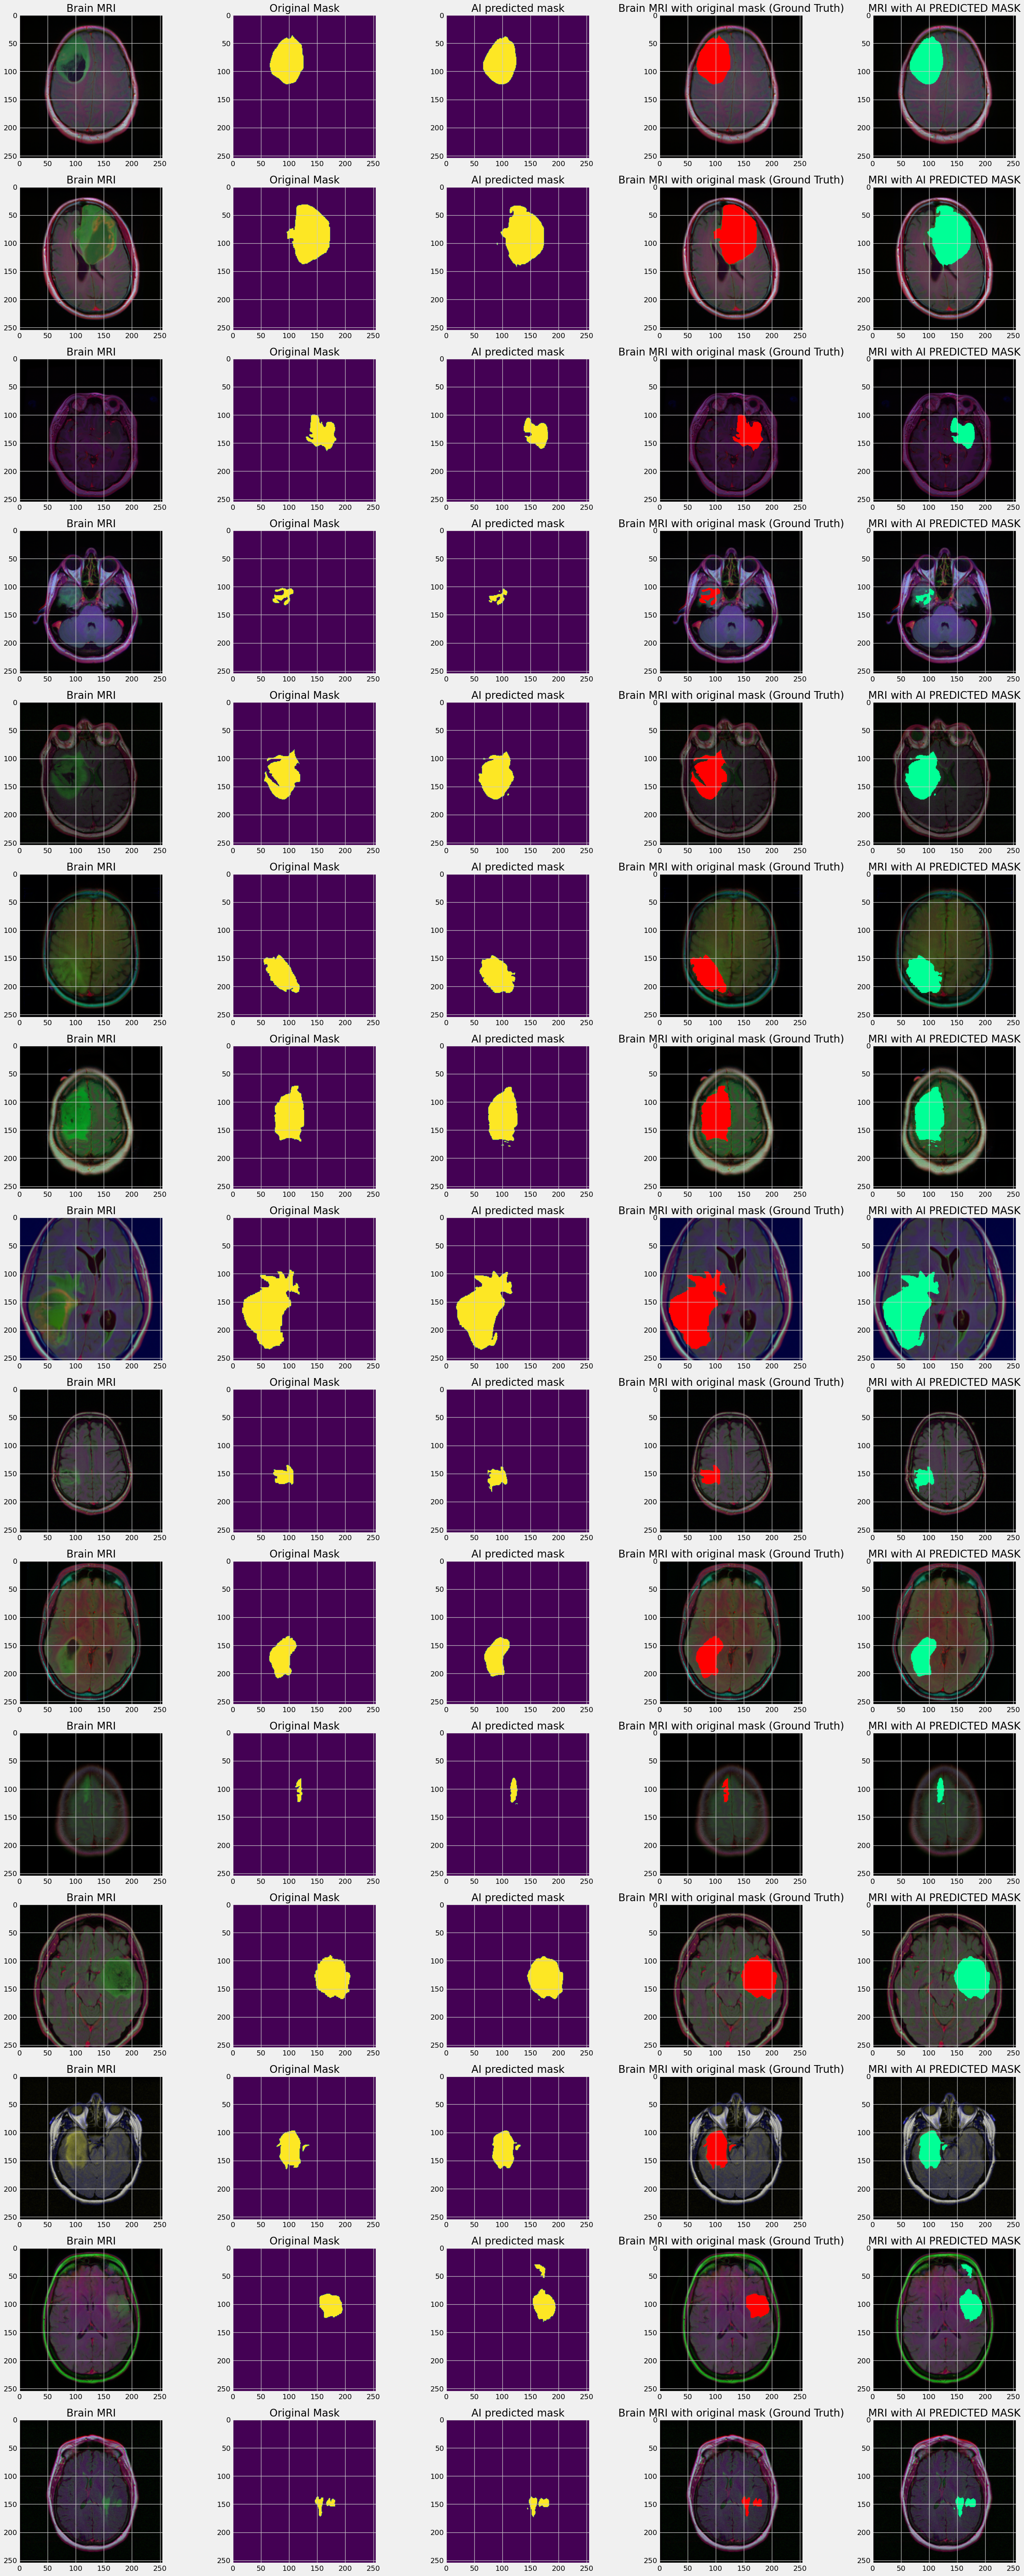

In [140]:
# visualizing prediction
count = 0
fig, axs = plt.subplots(15, 5, figsize=(30, 70))

for i in range(len(df_pred)):
    if df_pred.has_mask[i] == 1 and count < 15:
        # read mri images
        img = io.imread(df_pred.image_path[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[count][0].imshow(img)
        axs[count][0].title.set_text("Brain MRI")

        # read original mask
        mask = io.imread(df_pred.mask_path[i])
        axs[count][1].imshow(mask)
        axs[count][1].title.set_text("Original Mask")

        # read predicted mask
        pred = np.array(df_pred.predicted_mask[i]).squeeze().round()
        axs[count][2].imshow(pred)
        axs[count][2].title.set_text("AI predicted mask")

        # overlay original mask with MRI
        img[mask == 255] = (255, 0, 0)
        axs[count][3].imshow(img)
        axs[count][3].title.set_text("Brain MRI with original mask (Ground Truth)")

        # overlay predicted mask and MRI
        img_ = io.imread(df_pred.image_path[i])
        img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
        img_[pred == 1] = (0, 255, 150)
        axs[count][4].imshow(img_)
        axs[count][4].title.set_text("MRI with AI PREDICTED MASK")

        count += 1
    if count == 15:
        break

fig.tight_layout()